# Level 3: Advanced Architecture & Interpretability

**Objective**: Design custom/advanced architecture and implement interpretability (Grad-CAM).

**Architecture**: **EfficientNet-B0** (Fine-tuned). EfficientNet achieves much better accuracy/parameter effiency than ResNet.
**Interpretability**: **Grad-CAM** (Gradient-weighted Class Activation Mapping) to visualize where the model looks.

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
try:
    import cv2
except ImportError:
    print("OpenCV not found. Installing...")
    !pip install opencv-python
    import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Data Setup (Reusing Level 2 Augmentation)

In [ ]:
class MergedFlowersDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.loader = datasets.folder.default_loader
    def __len__(self): return len(self.image_files)
    def __getitem__(self, idx):
        try:
            return self.transform(self.loader(self.image_files[idx])), self.labels[idx]
        except Exception as e:
            print(f"Error loading {self.image_files[idx]}: {e}")
            raise e

def get_data(num_workers=0):
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.2,0.1), transforms.ToTensor(), transforms.Normalize(mean, std)
    ])
    val_tf = transforms.Compose([
        transforms.Resize((256,256)), transforms.CenterCrop(224),
        transforms.ToTensor(), transforms.Normalize(mean, std)
    ])
    
    all_samples, all_labels = [], []
    for s in ['train', 'val', 'test']:
        try:
            ds = datasets.Flowers102('./data', split=s, download=True)
            all_samples.extend(ds._image_files); all_labels.extend(ds._labels)
        except: pass
    
    idx = np.arange(len(all_samples))
    train_i, tmp = train_test_split(idx, test_size=0.2, stratify=all_labels, random_state=42)
    val_i, test_i = train_test_split(tmp, test_size=0.5, stratify=np.array(all_labels)[tmp], random_state=42)
    
    dds = {
        'train': MergedFlowersDataset([all_samples[i] for i in train_i], [all_labels[i] for i in train_i], train_tf),
        'val': MergedFlowersDataset([all_samples[i] for i in val_i], [all_labels[i] for i in val_i], val_tf),
        'test': MergedFlowersDataset([all_samples[i] for i in test_i], [all_labels[i] for i in test_i], val_tf)
    }
    
    loaders = {x: DataLoader(dds[x], batch_size=32, shuffle=(x=='train'), num_workers=num_workers) for x in dds}
    return loaders, {x: len(dds[x]) for x in dds}

dataloaders, sizes = get_data(num_workers=0)

100%|██████████| 345M/345M [00:34<00:00, 9.97MB/s] 
100%|██████████| 502/502 [00:00<00:00, 91.0kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 3.14MB/s]


## 2. Advanced Architecture: EfficientNet-B0
We use EfficientNet because it scales dimensions (depth/width/resolution) uniformly, offering better accuracy-to-compute ratio than ResNet.

In [ ]:
def build_efficientnet():
    model = models.efficientnet_b0(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = True
   
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 102)
    
    model = model.to(device)
    return model

model_eff = build_efficientnet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_eff.parameters(), lr=1e-4, weight_decay=1e-4)

c:\Users\sansk\PROJECTS\terafac\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sansk\PROJECTS\terafac\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\sansk/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:01<00:00, 15.7MB/s]


## 3. Training Loop

In [4]:
def train(model, epochs=15):
    best_acc = 0.0
    os.makedirs('models', exist_ok=True)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()
            
            running_acc = 0.0
            running_corrects = 0
            total_samples = 0
            
            for x, y in dataloaders[phase]:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    out = model(x)
                    _, pred = torch.max(out, 1)
                    loss = criterion(out, y)
                    if phase=='train': 
                        loss.backward()
                        optimizer.step()
                
                running_corrects += torch.sum(pred == y).item()
                total_samples += y.size(0)
            
            epoch_acc = running_corrects / total_samples
            print(f"{phase} Acc: {epoch_acc:.4f}")
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'models/level_3_efficientnet.pth')
    return model

# Training
model_eff = train(model_eff, epochs=15)

Epoch 1/15
train Acc: 0.2929
val Acc: 0.6398
Epoch 2/15
train Acc: 0.6704
val Acc: 0.8584
Epoch 3/15
train Acc: 0.8266
val Acc: 0.9316
Epoch 4/15
train Acc: 0.8848
val Acc: 0.9499
Epoch 5/15
train Acc: 0.9112
val Acc: 0.9658
Epoch 6/15
train Acc: 0.9246
val Acc: 0.9683
Epoch 7/15
train Acc: 0.9315
val Acc: 0.9731
Epoch 8/15
train Acc: 0.9370
val Acc: 0.9744
Epoch 9/15
train Acc: 0.9454
val Acc: 0.9805
Epoch 10/15
train Acc: 0.9464
val Acc: 0.9756
Epoch 11/15
train Acc: 0.9464
val Acc: 0.9768
Epoch 12/15
train Acc: 0.9516
val Acc: 0.9768
Epoch 13/15
train Acc: 0.9553
val Acc: 0.9744
Epoch 14/15
train Acc: 0.9499
val Acc: 0.9792
Epoch 15/15
train Acc: 0.9579
val Acc: 0.9768


## 4. Grad-CAM Visualization
Visualizing the last convolutional layer activations to see which flower parts the model focuses on.

c:\Users\sansk\PROJECTS\terafac\venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


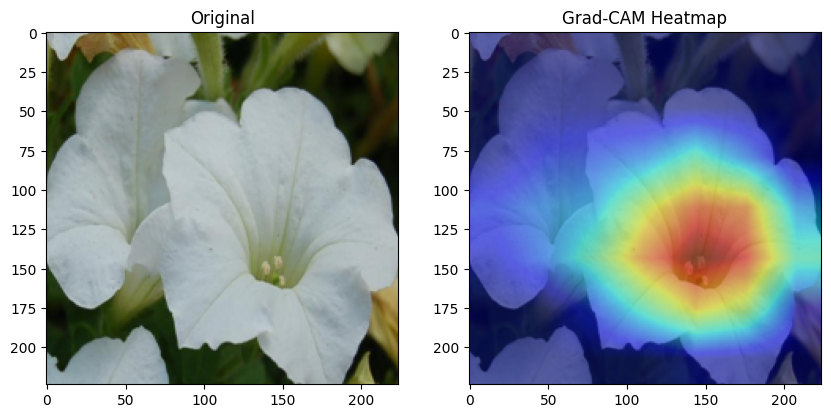

In [5]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        output[0, class_idx].backward()
        
        gradients = self.gradients.data.cpu().numpy()[0]
        activations = self.activations.data.cpu().numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
            
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

target_layer = model_eff.features[-1] 
grad_cam = GradCAM(model_eff, target_layer)

img_tensor, label = next(iter(dataloaders['test']))
img_tensor = img_tensor[0:1].to(device)

heatmap = grad_cam(img_tensor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")

disp_img = img_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
disp_img = disp_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
disp_img = np.clip(disp_img, 0, 1)
plt.imshow(disp_img)

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(disp_img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.show()